# Image Normalization Options

Let's start by running cellpose on an image and looking at the results.

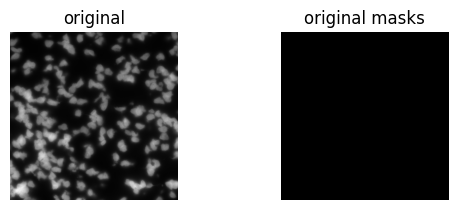

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from cellpose import io, models


img = io.imread('../../resources/raw_3.tif')
model = models.CellposeModel(gpu=True, model_type='cyto')
masks = model.eval(img, diameter=60, normalize=False)[0]

plt.subplot(2,2,1)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('original')

plt.subplot(2,2,2)
plt.imshow(masks)
plt.axis('off')
plt.title('original masks')

plt.show()

In this example, cellpose didn't find any masks. We can look at the histogram of pixel values to see that the image is very dark and the pixel values are not well distributed over the range of possible values.

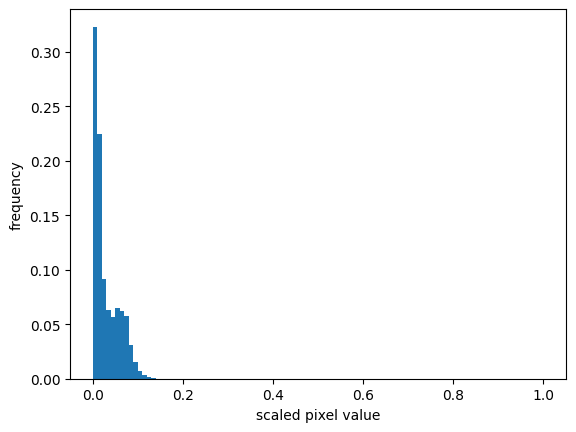

In [2]:
scaled_img = img / np.iinfo(img.dtype).max
plt.hist(scaled_img.ravel(), 
         bins=100, 
         range=(0, 1),
         weights=np.zeros_like(scaled_img.ravel()) + 1. / scaled_img.size) # convert to frequency distribution
plt.xlabel("scaled pixel value")
plt.ylabel("frequency")
plt.show()

Because the input image's data is concentrated in the lower part of the bit range, the scaled data is processed with incorrectly small values. We can normalize the image to improve the results. There are several options for normalization. The first is to normalize the image 1st and 99th percentiles to the range [0,1]. This is the default normalization method when using `transforms.normalize_img()`.

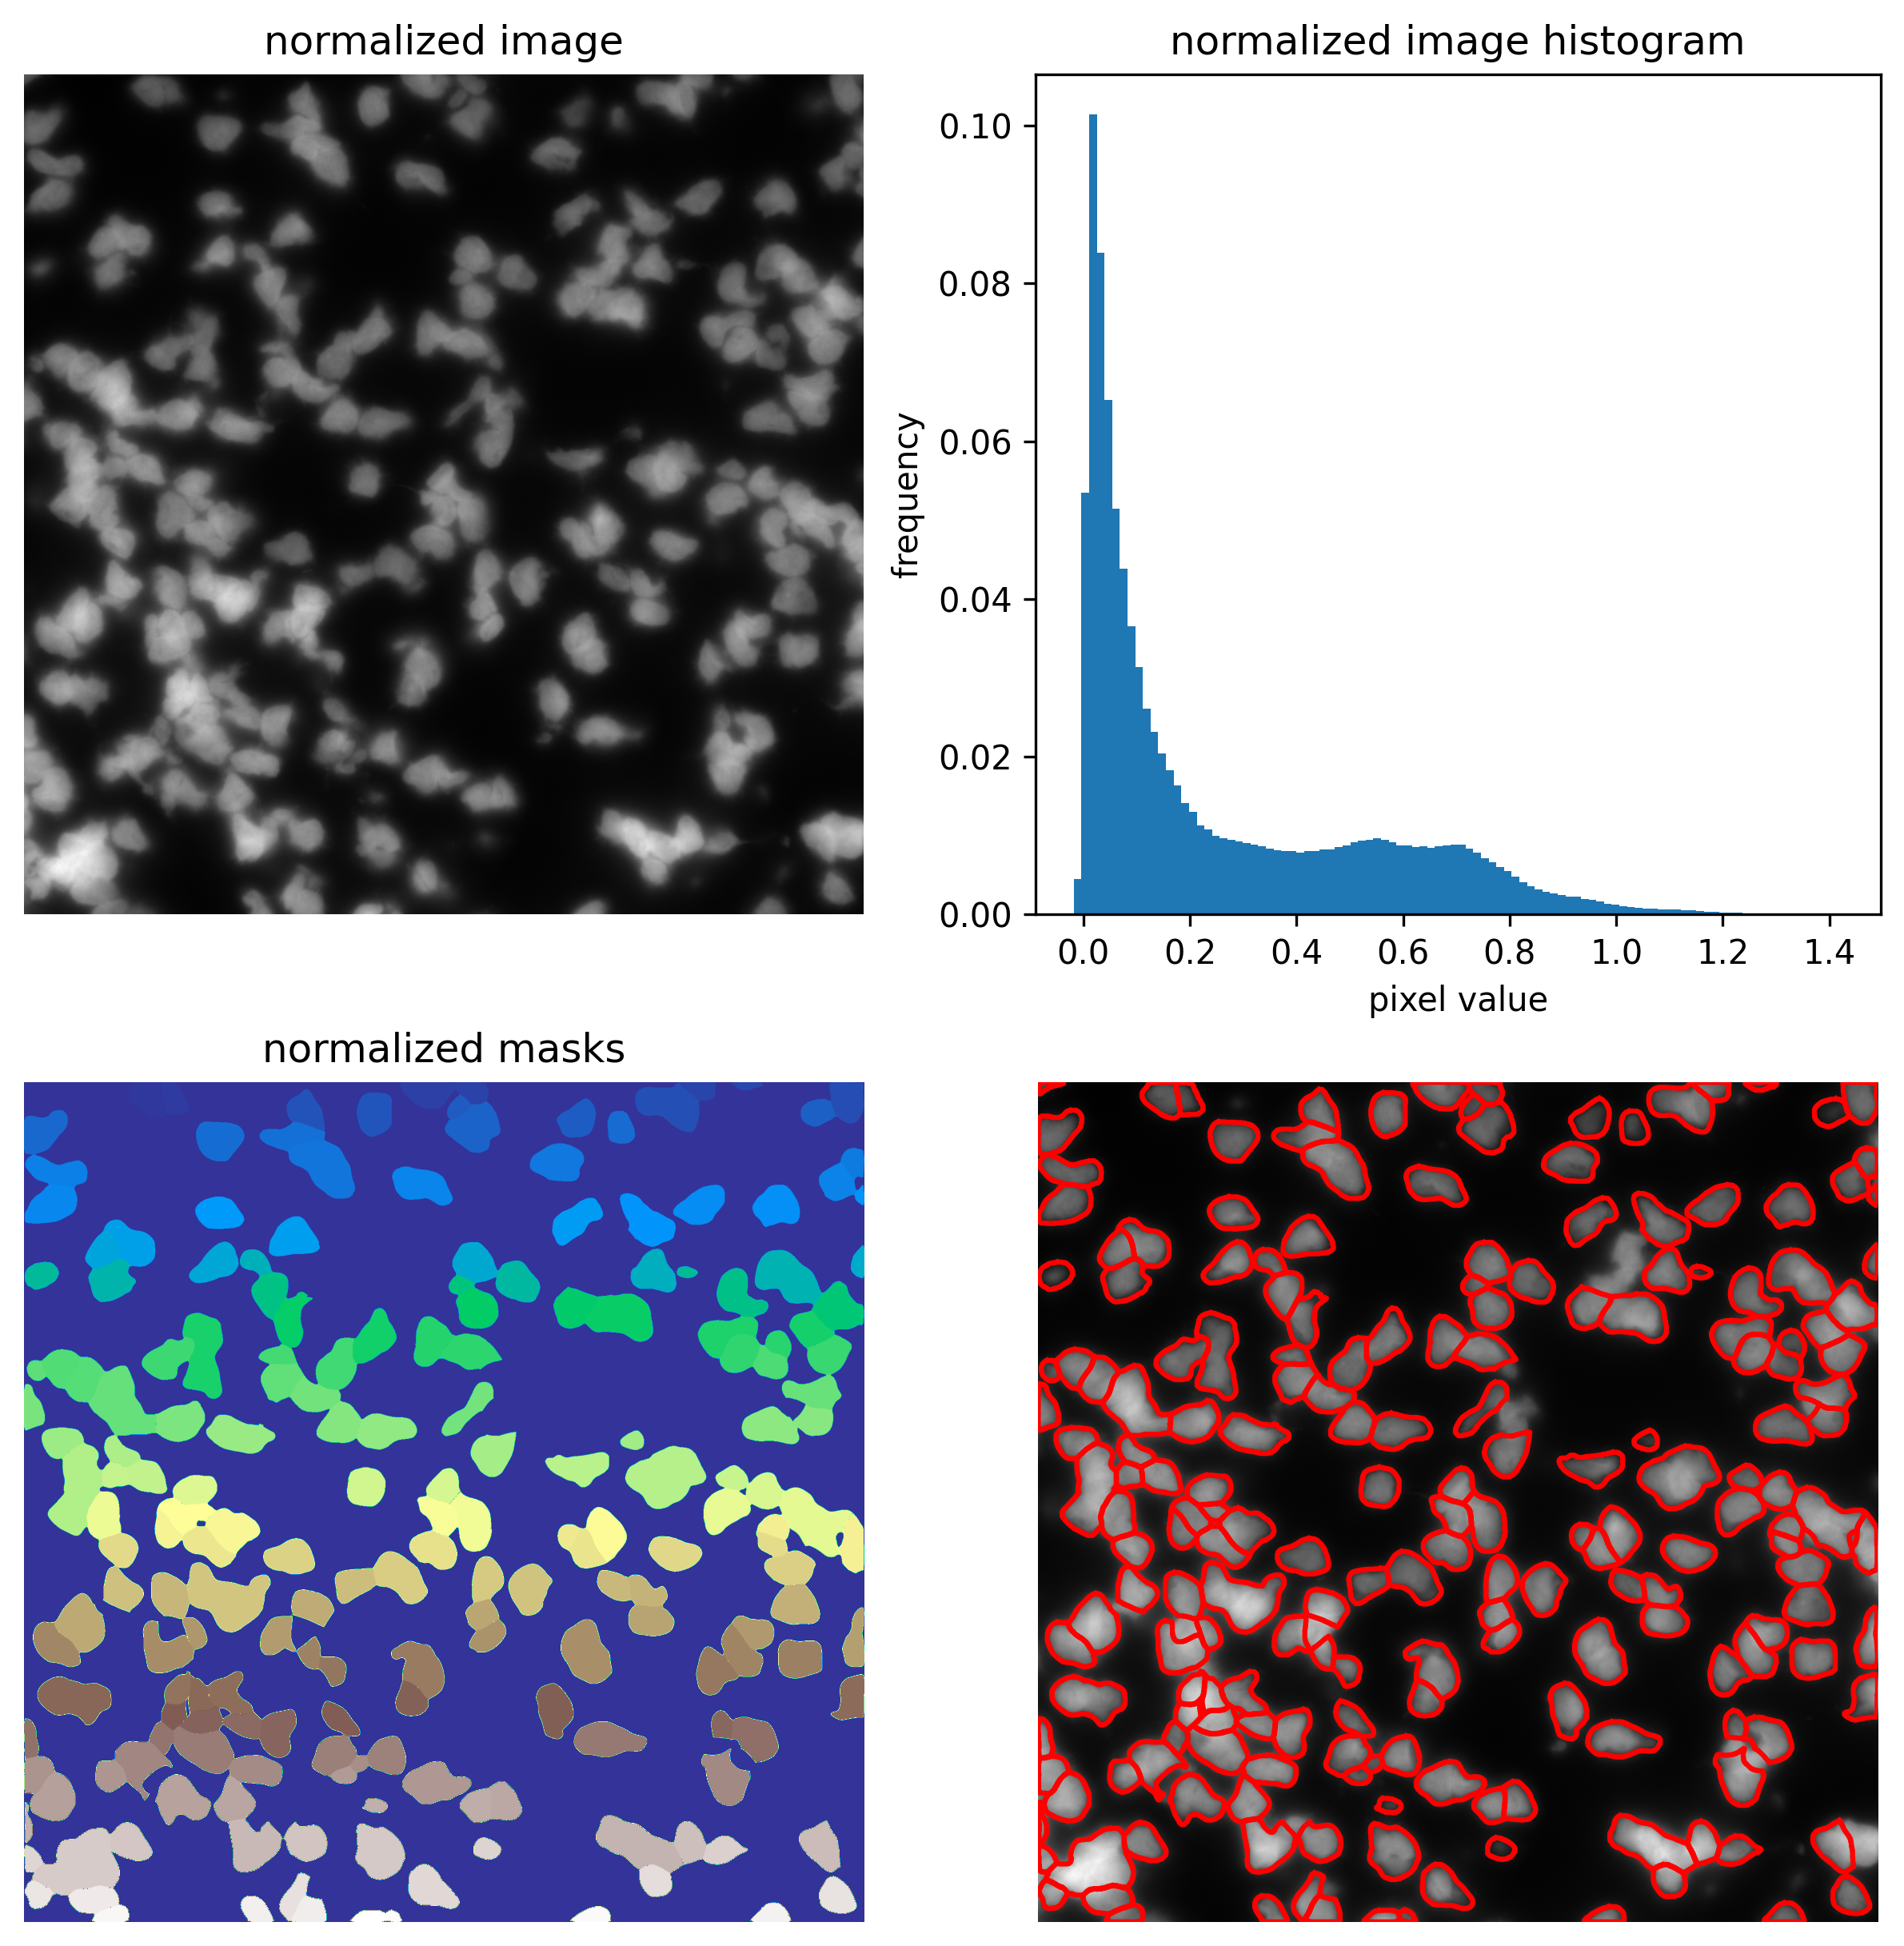

Number of cells found: 204


In [6]:
from cellpose import transforms, utils


img_norm = transforms.normalize99(img)
# use transforms.normalize_img(img_rgb, normalize=True) if the input image is RGB
masks_norm = model.eval(img_norm, diameter=60, normalize=False)[0]
outlines = utils.outlines_list(masks_norm)


plt.figure(figsize=(10,10), dpi=300)
# plot original image after normalization
plt.subplot(2, 2, 1)
plt.imshow(img_norm, cmap='gray')
plt.axis('off')
plt.title("normalized image")

# plot histogram of pixel values
plt.subplot(2, 2, 2)
plt.hist(img_norm.ravel(),
         bins=100, 
         weights=np.zeros_like(img_norm.ravel()) + 1. / img_norm.size) # convert to frequency distribution
plt.xlabel("pixel value")
plt.ylabel("frequency")
plt.title("normalized image histogram")

# plot masks
plt.subplot(2, 2, 3)
plt.imshow(masks_norm, cmap='terrain')
plt.axis('off')
plt.title("normalized masks")

# plot masks on top of image
plt.subplot(2, 2, 4)
plt.imshow(img_norm, cmap='gray')
for o in outlines:
    plt.plot(o[:,0], o[:,1], 'r')
plt.axis('off')
plt.title("normalized masks on image")

plt.show()

print(f"Number of cells found: {len(np.unique(masks_norm))}")

This is a significant improvement!

Because the training data was percentile normalized on the [0, 1] interval, input images should be likewise normalized.

Still, with additional normalization, we might get better segmentation out of Cellpose. Since the edges of the object are a bit fuzzy, it might help to use the sharpening option:

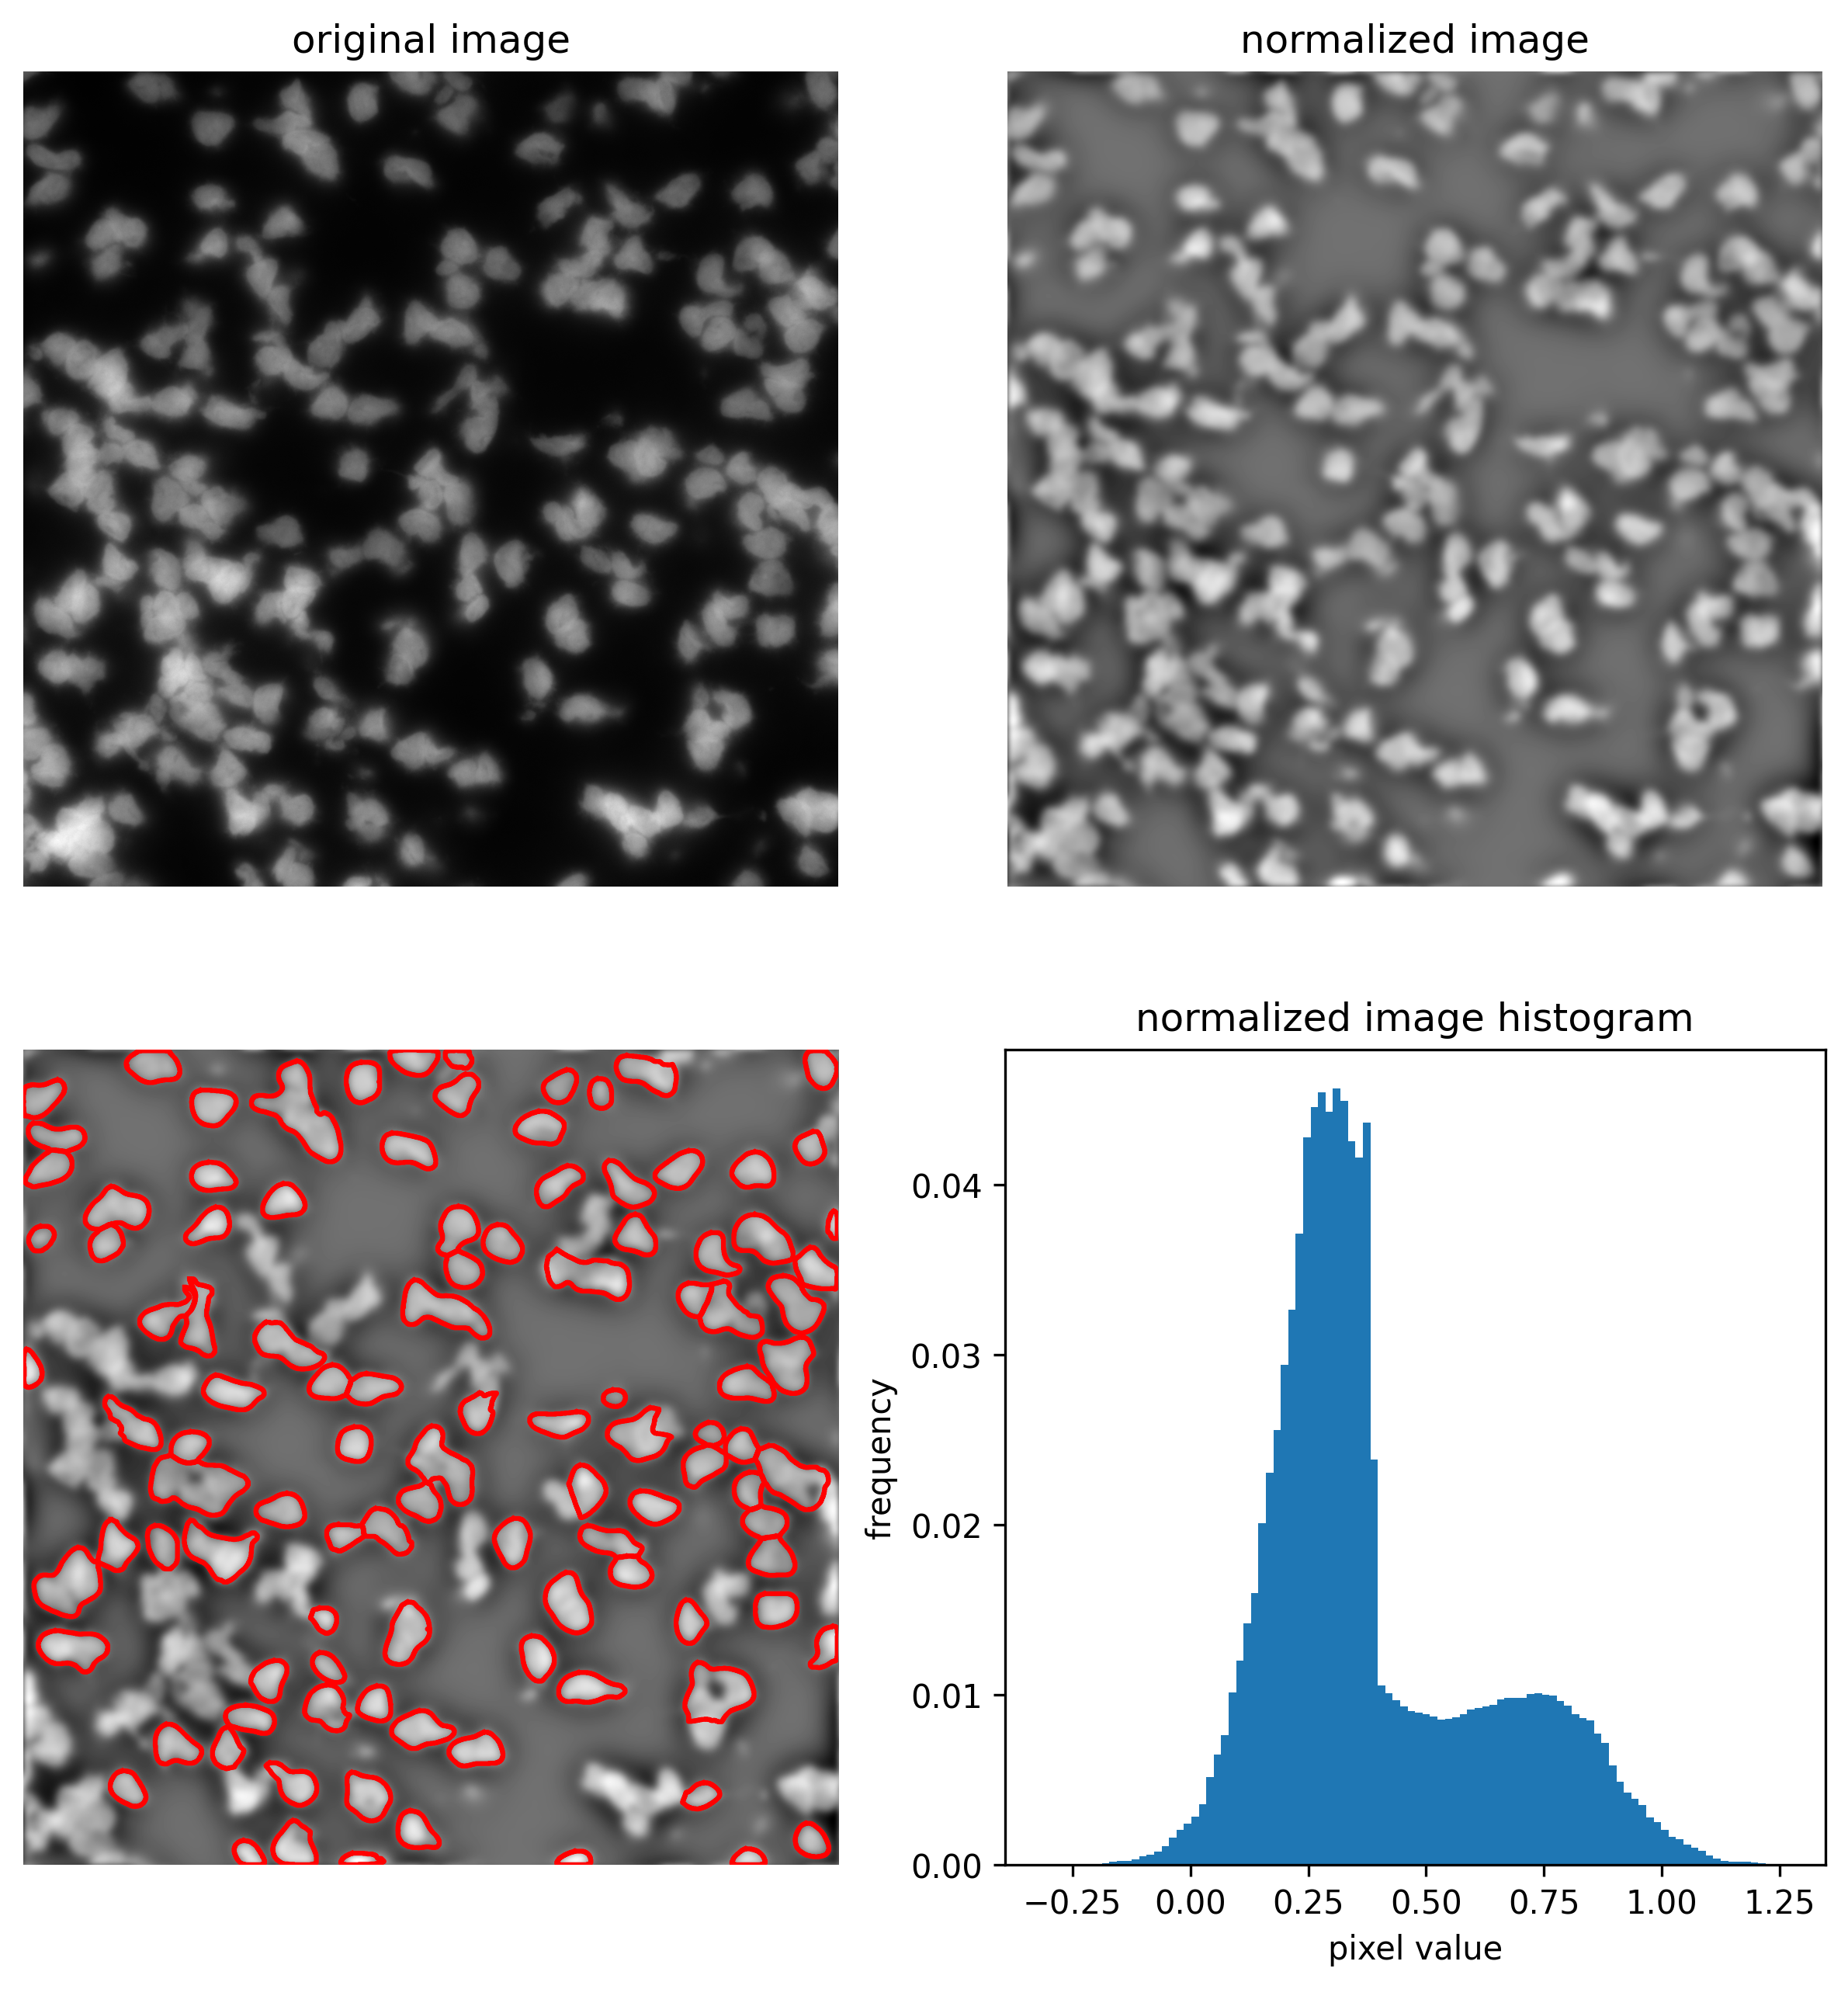

In [7]:
# percentile norm before or after????

img_sharp = transforms.smooth_sharpen_img(img, sharpen_radius=40, smooth_radius=8) # this shifts the image values to be negative, so we need to normalize after
img_sharp = transforms.normalize99(img_sharp)

masks_sharp = model.eval(img_sharp, diameter=60, normalize=False)[0]
outlines_sharp = utils.outlines_list(masks_sharp)

plt.figure(figsize=(10,10), dpi=300)
plt.subplot(2, 2, 1)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title("original image")

plt.subplot(2, 2, 2)
plt.imshow(img_sharp, cmap='gray')
plt.axis('off')
plt.title("normalized image")

plt.subplot(2, 2, 3)
plt.imshow(img_sharp, cmap='gray')
for o in outlines_sharp:
    plt.plot(o[:,0], o[:,1], 'r')
plt.axis('off')

# plot histogram of pixel values
plt.subplot(2, 2, 4)
plt.hist(img_sharp.ravel(),
         bins=100,
         weights=np.zeros_like(img_sharp.ravel()) + 1. / img_sharp.size)
plt.xlabel("pixel value")
plt.ylabel("frequency")
plt.title("normalized image histogram")
plt.show()


### Tile Normalization

Tile normalization can be useful to normalize the intensity of unevenly illuminated images.

Image needs to have at least 3 dimensions


ValueError: Image needs to have at least 3 dimensions

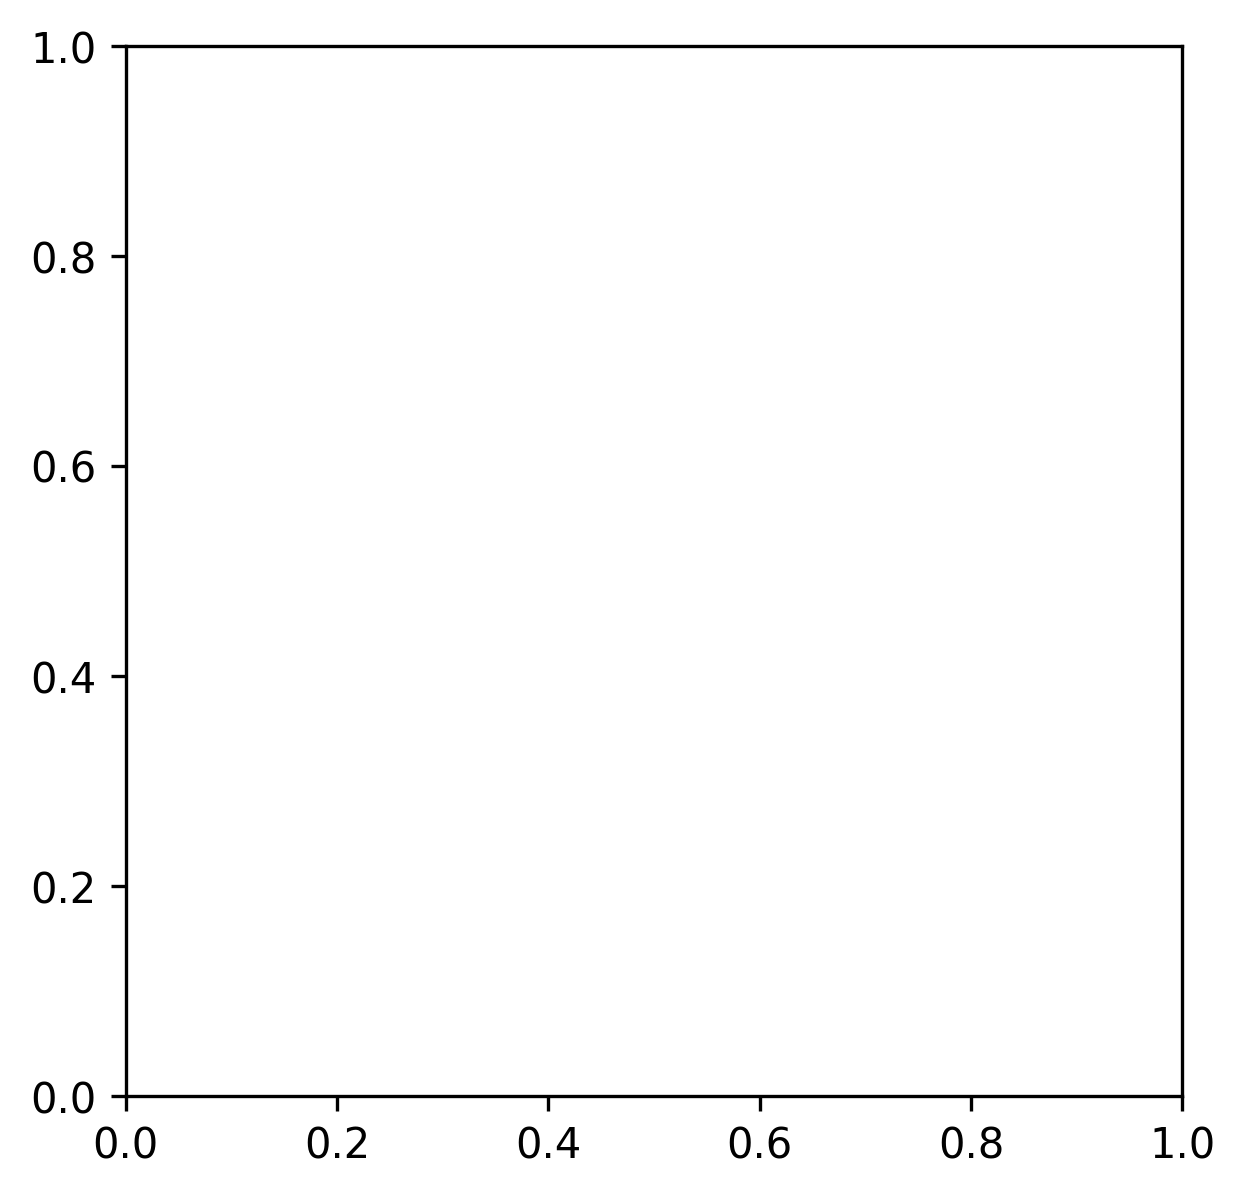

In [21]:
plt.figure(figsize=(10,10), dpi=300)
plt.subplot(2,2,1)
img2 = io.imread('../../resources/slice.tif')

img_slice = transforms.normalize_img(img)   #[0,25].transpose(1,2,0).copy())
img_slice_norm = transforms.normalize99_tile(img_slice, blocksize=100)

plt.subplot(2,2,2)
plt.imshow(img_slice_norm, cmap='gray')

model = models.CellposeModel(gpu=True, model_type='TN1')
masks = model.eval(img_slice, diameter=10, channels=[2,1], normalize=False)[0]


#
# plt.figure(figsize=(14,14), dpi=300)
# for k, (img, mask) in enumerate(zip([img_slice, img_slice_norm], [masks, masks2])):
#     img_rgb = np.concatenate((img, np.zeros_like(img)[:,:,:1]), axis=-1)
#     img_rgb = np.clip(img_rgb, 0, 1)
#     plt.subplot(2,2,1+(k%2))
#     plt.imshow(img_rgb)
#     plt.axis('off')
#     plt.title(['original', 'tile normalization'][k])
#
#     plt.subplot(2,2,3+(k%2))
#     plt.imshow(img_rgb)
#     outlines = utils.outlines_list(mask)
#     for o in outlines:
#         plt.plot(o[:,0], o[:,1], color='w', lw=0.5)
#     plt.axis('off')
#     plt.title(f'{mask.max()} cells found')
#
# plt.tight_layout()
plt.show()

In [ ]:
|from cellpose import transforms

#img = transforms.smooth_img(img, sigma=6)
img_sharpen = transforms.smooth_sharpen_img(img, sharpen_radius=40, smooth_radius=8)
# img_sharpen = transforms.normalize99(img_sharpen)
print(img_sharpen.min(), img_sharpen.max())
model = models.CellposeModel(gpu=True, model_type='cyto')
masks = model.eval(img_sharpen, diameter=60, flow_threshold=0.4, cellprob_threshold=0)[0]

plt.figure(figsize=(6.5,3))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_sharpen, cmap='gray')
plt.axis('off')

plt.figure(figsize=(6.5,3))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
outlines = utils.outlines_list(masks)
plt.imshow(img_sharpen, cmap='gray')
for o in outlines:
    plt.plot(o[:,0], o[:,1], 'r')
plt.axis('off')